In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import *
from iminuit import Minuit, describe, Struct

# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw

# Siddharth and Laura's Stuff
from NPTFit import create_mask as cm
import constants_noh as constants
import units

In [2]:
trials = 1
channel = 'b'
Nb = 1
conc = "SP"
xsec = 1e-25
marr = [100]
ebins = [2,20]

In [3]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('fermi_data/fermidata_exposure.npy'))
#mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
mask = cm.make_mask_total(band_mask = False )
area_rat = (len(mask[~mask]))/len(mask)

In [4]:
# Defining some constants
r_s = 199 # scale radius, [kpc]
alpha = 0.678
N_calib = 150. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e12 # [M_s]
mMin_calib = 1e8 # [M_s]
mMax_calib = 1e10 # [M_s]
mMin = 1e-9*M_MW
mMax = 0.01*M_MW # [M_s]
min_flux =np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask])))

In [5]:
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)

N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos
N_subs = np.random.poisson(N_subs)
print(N_subs)

m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 8000) # mass values to test
def mCDFInv(r):
    return ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*r)**(-1/.9)

rho_s2 = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, constants.r_vir)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

4424972


In [6]:
r_arr = np.logspace(0, np.log10(260), 60500) # radius values to test
r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_Ein(r), r_arr, nsamples=N_subs)
m_sampler = InverseTransform.InverseTransform(dNdm_func, m_arr, nsamples=N_subs, cdfinv=mCDFInv)

In [7]:
PS_arr = []
F_arr = []
flux_bins = np.logspace(-15, -6, 8*8)

for i in tqdm_notebook(range(trials)):
    rval_arr = r_sampler.sample()
    mval_arr = m_sampler.sample()

    theta_arr = (np.arccos(2*np.random.rand(N_subs)-1))
    phi_arr = (2*np.pi*np.random.rand(N_subs))

    PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
    PS_set.calcJ(conc)
    PS_arr.append(PS_set)
    
    if i == 0: PPnoxsec = PS_set.PPnoxsec(marr[0], ebins, channel)
    F_arr.append(np.histogram(PS_set.J.value[~mask[PS_set.pixels]] * xsec * PPnoxsec, bins=flux_bins)[0])

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
/group/hepheno/heptools/anaconda3/envs/venv_py35/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [8]:
print(np.mean(PS_set.c))

10.0


In [9]:
min_flux_ind = np.argmin(np.abs(flux_bins - 0)) #10.**(min_flux)))
flux_bins2 = flux_bins[min_flux_ind:]
F_arr = np.array(F_arr).astype(float)
for i in range(len(F_arr)):
    F_arr[i][F_arr[i]==0] = 1e-50

F_ave = (np.median(F_arr, axis=0))[min_flux_ind:]
max_flux = np.log10(flux_bins2[np.argmax(F_ave < 1e-20)])

dF = np.diff(flux_bins2)
dN = np.array(F_ave)/(4*np.pi*(180/np.pi)**2*area_rat)
F = (np.array(flux_bins2)[:-1]+np.array(flux_bins2)[1:])/2.

/group/hepheno/heptools/anaconda3/envs/venv_py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: InitialParamWarning: errordef is not given. Default to 1.
  if __name__ == '__main__':


FCN = 0.0 
 TOTAL NCALL = 16 
 NCALLS = 16 
 
 
 EDM = 0.0 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,A,-14,8.53807,0,0,-16.0,1.0,
2,n1,0.01,14.943,0,0,-10.0,10.0,
3,n2,-10,1,0,0,,,FIXED
4,Fb1,-10.8571,1,0,0,,,FIXED


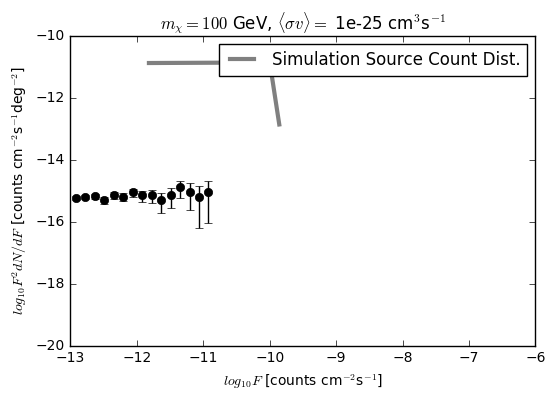

array([-15.43054065, -15.41662627, -15.38747469, -15.35919763,
       -15.34357311, -15.36260772, -15.32036067, -15.29705679,
       -15.28945465, -15.30932481, -15.26110586, -15.36938684,
       -15.2402094 , -15.29117228, -15.23186119, -15.18427211,
       -15.17462623, -15.3006144 , -15.13755387, -15.19099138,
       -15.04813423, -15.14831514, -15.13039673, -15.28856959,
       -15.14571244, -14.87791656, -15.03608942, -15.19426227,
       -15.05140513, -64.90854798, -64.76569084, -64.6228337 ,
       -64.47997656, -64.33711941, -64.19426227, -64.05140513,
       -63.90854798, -63.76569084, -63.6228337 , -63.47997656,
       -63.33711941, -63.19426227, -63.05140513, -62.90854798,
       -62.76569084, -62.6228337 , -62.47997656, -62.33711941,
       -62.19426227, -62.05140513, -61.90854798, -61.76569084,
       -61.6228337 , -61.47997656, -61.33711941, -61.19426227,
       -61.05140513, -60.90854798, -60.76569084, -60.6228337 ,
       -60.47997656, -60.33711941, -60.19426227])
array

In [10]:
#plt.figure(figsize=(5,5))
#img = plt.imread("../LauraF2dNdF/100"+str(xsec)+".png")
#plt.imshow(img, extent=[-13,-6, -20,-10], aspect='auto')

poisson = (trials==1)

yerr_up = (AssortedFunctions.PandGErrors(F_arr, poisson))[1][min_flux_ind:]
yerr_up = yerr_up/np.log(10) / dN /(4*np.pi*(180/np.pi)**2*area_rat)

yerr_dn = (AssortedFunctions.PandGErrors(F_arr, poisson))[0][min_flux_ind:]
yerr_dn = yerr_dn/np.log(10) / dN /(4*np.pi*(180/np.pi)**2*area_rat)
delta_flux = max_flux - min_flux
exec(PowerLaw.genMinuitString( Nb, "-14", "(-16,1)", "1.", "0.01", "(-10.,10.)", "1e-3", "-0.5", "(0, "+str(delta_flux)+")", ".1", "-10.", str(max_flux), vmin=min_flux, vmax=max_flux ))
minuit.migrad()
results = []
for val in minuit.values:
    results.append(minuit.values[val])
plt.errorbar(myLog(F), myLog(F**2*dN/dF), yerr=[yerr_up, yerr_dn], fmt='o', c="black")
F_test = np.logspace(min_flux-1, max_flux+1, 8*8)
plt.plot(myLog(F_test), PowerLaw.simple_power(myLog(F_test), *results), zorder=5, linewidth=3, c="grey", label="Simulation Source Count Dist.") #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))
plt.xlim(-13, -6)
plt.ylim(-20, -10)
plt.title("$m_{\chi} = "+str(marr[0])+"$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
plt.legend()
plt.show()
plt.close()
print(repr(myLog(F**2*dN/dF)))
print(repr(myLog(F)))

8.0


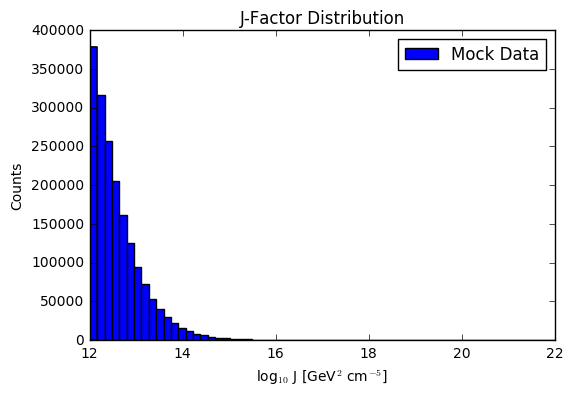

In [11]:
bins = plt.hist(np.log10(PS_set.J.value), bins=np.linspace(12,22,64), label="Mock Data")
plt.title("J-Factor Distribution")
plt.ylabel("Counts")
plt.xlabel("log$_{10}$ J [GeV$^2$ cm$^{-5}$]")
plt.legend()
print(np.sum(bins[0][bins[1][:-1]>18]))

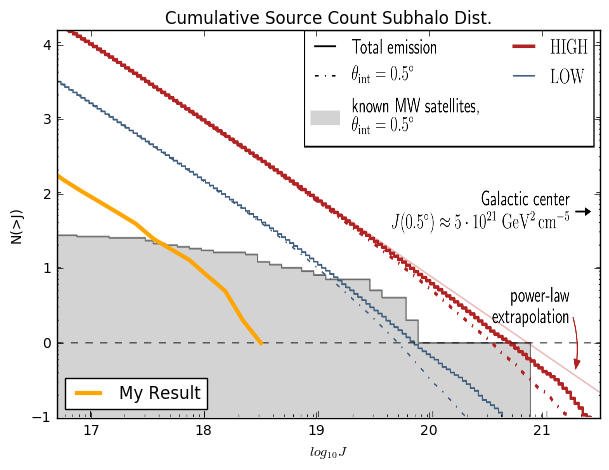

In [12]:
plt.figure(figsize=(7,5))
img = plt.imread("../clumpy.png")
plt.imshow(img, extent=[16.7,21.51, -1,4.3], aspect='auto')

cum_J = []
N = np.sum(bins[0])
for J in bins[0]:
    cum_J.append(N)
    N -= J
#plt.plot(bins[1], 20.-bins[1], alpha=0.5)
plt.plot(bins[1][:-1], np.log10(cum_J), c="orange", linewidth=3, label="My Result")
plt.xlim(16.7, 21.51)
plt.ylim(-1,4.2)
plt.xlabel("$log_{10}J$")
plt.ylabel("N(>J)")
plt.title("Cumulative Source Count Subhalo Dist.")
plt.legend(loc=3)

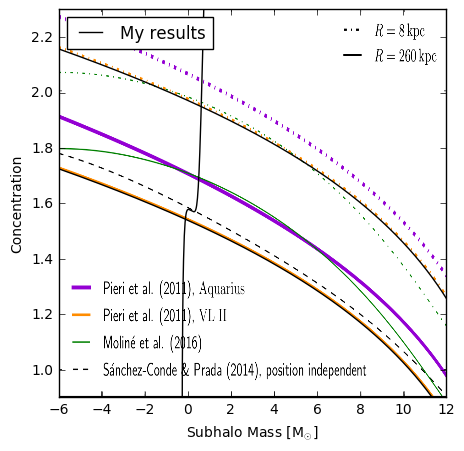

In [13]:
plt.figure(figsize=(5,5))
img = plt.imread("../clumpy1.png")
plt.imshow(img, extent=[-6,12, myLog(8),myLog(200)], aspect='auto')

mass_test_arr = np.logspace(-6,12,1000)
plt.plot(myLog(mass_test_arr), myLog(PS_set.c200_SP(mass_test_arr*units.M_s, 1, 1)), c="black", linewidth=1, label="My results")
plt.plot(myLog(mass_test_arr), myLog(PS_set.c200_S(mass_test_arr*units.M_s, np.ones(1000)*260*units.kpc, 1)), c="black", linewidth=1)
plt.plot(myLog(mass_test_arr), myLog(PS_set.c200_S(mass_test_arr*units.M_s, np.ones(1000)*8*units.kpc, 1)), c="black", linewidth=1)
plt.ylim(myLog(8), myLog(200))
plt.xlim(-6, 12)
plt.legend(loc=2)
plt.ylabel("Concentration")
plt.xlabel("Subhalo Mass [M$_{\odot}$]")

In [14]:
r_test = np.logspace(-3, myLog(213.5*1.22), 1000)
r_hist = np.histogram(PS_set.Rvir, r_test*units.kpc);
N_cum = [0]
for ir, r in enumerate(r_test[:-1]):
    N_cum.append(N_cum[-1]+r_hist[0][ir])
N_cum = np.array(N_cum) / N_cum[np.argmin(np.abs(213.5-r_test))]

(array(-2.30103), array(0.11394335))

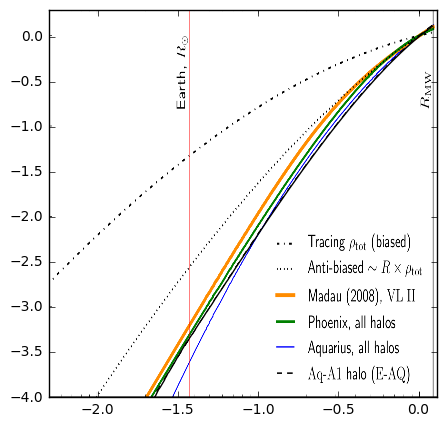

In [15]:
plt.figure(figsize=(5,5))
img = plt.imread("../clumpy2.png")
plt.imshow(img, extent=[myLog(5e-3),myLog(1.5), -4,myLog(2)], aspect='auto')

plt.plot(myLog(r_test/213.5), np.log10(N_cum), c="black")
plt.ylim(-4, myLog(2))
plt.xlim(myLog(5e-3), myLog(1.3))

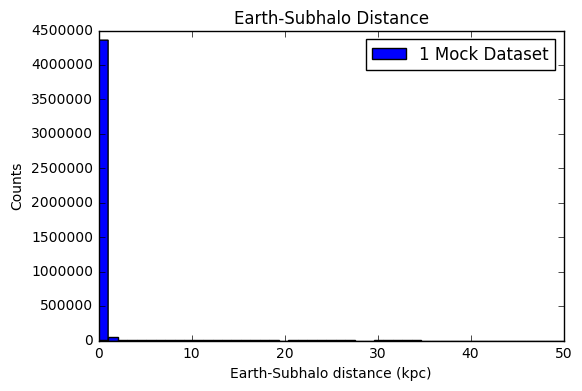

In [16]:
plt.hist(PS_set.r200/units.kpc, bins=np.linspace(0,50,50), label="1 Mock Dataset");
plt.xlabel("Earth-Subhalo distance (kpc)")
plt.ylabel("Counts")
plt.legend()
plt.title("Earth-Subhalo Distance")

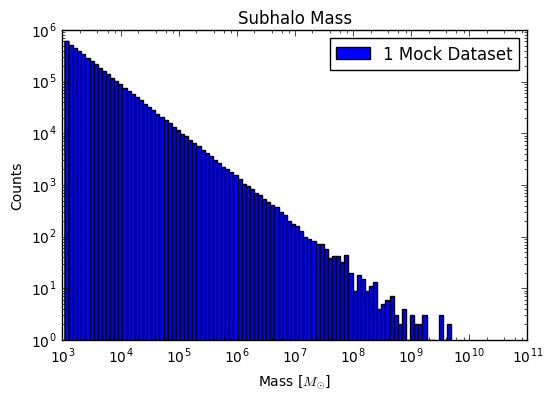

In [17]:
plt.hist(PS_set.Mvir/units.M_s, bins=np.logspace(myLog(mMin), myLog(mMax), 100), label="1 Mock Dataset")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Counts")
plt.xlabel("Mass [$M_{\odot}$]")
plt.legend()
plt.title("Subhalo Mass")

(0, 6.283185307179586)

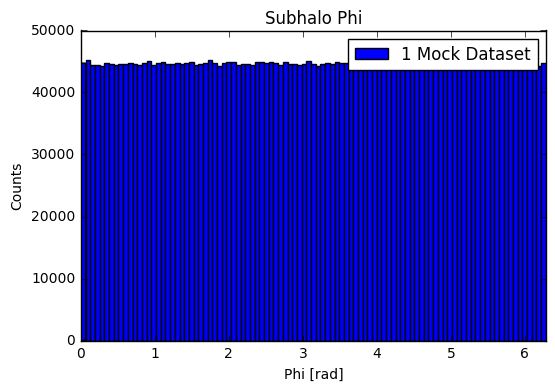

In [18]:
plt.hist(PS_set.phi, bins=np.linspace(0,2*np.pi,100), label="1 Mock Dataset")
plt.xlabel("Phi [rad]")
plt.ylabel("Counts")
plt.legend()
plt.title("Subhalo Phi")
plt.xlim(0,2*np.pi)

(0, 3.141592653589793)

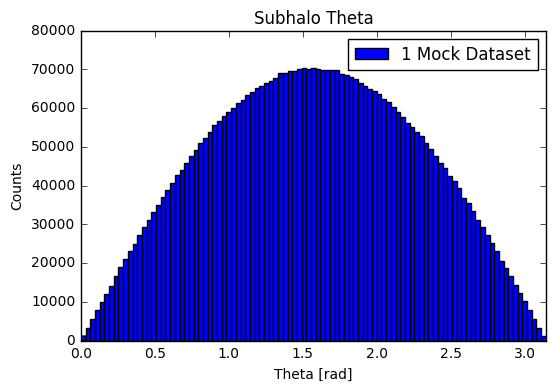

In [19]:
plt.hist(PS_set.theta, bins=np.linspace(0,np.pi,100), label="1 Mock Dataset")
plt.xlabel("Theta [rad]")
plt.ylabel("Counts")
plt.legend()
plt.title("Subhalo Theta")
plt.xlim(0,np.pi)

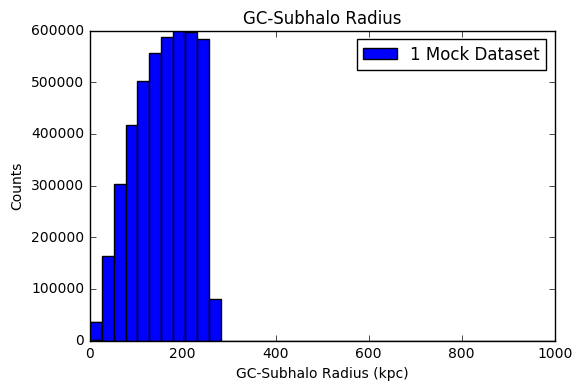

In [20]:
plt.hist(PS_set.Rvir/units.kpc, bins=np.linspace(0,1000,40), label="1 Mock Dataset");
plt.xlabel("GC-Subhalo Radius (kpc)")
plt.ylabel("Counts")
plt.legend()
plt.title("GC-Subhalo Radius")

In [38]:
J_bins = np.logspace(12, 22, 64)
J_hist = np.zeros(63)
for f in os.listdir("PS_J"):
    print(f)
    J = np.load("PS_J/"+f)
    J_hist += np.histogram(J, J_bins)[0]/len(os.listdir("PS_J"))

PS_J53.npy
PS_J156.npy
PS_J81.npy
PS_J3.npy
PS_J130.npy
PS_J35.npy
PS_J263.npy
PS_J185.npy
PS_J279.npy
PS_J147.npy
PS_J237.npy
PS_J87.npy
PS_J273.npy
PS_J39.npy
PS_J21.npy
PS_J40.npy
PS_J1.npy
PS_J129.npy
PS_J117.npy
PS_J271.npy
PS_J13.npy
PS_J72.npy
PS_J150.npy
PS_J115.npy
PS_J149.npy
PS_J181.npy
PS_J223.npy
PS_J95.npy
PS_J144.npy
PS_J85.npy
PS_J124.npy
PS_J50.npy
PS_J167.npy
PS_J222.npy
PS_J92.npy
PS_J163.npy
PS_J238.npy
PS_J255.npy
PS_J140.npy
PS_J192.npy
PS_J258.npy
PS_J36.npy
PS_J193.npy
PS_J173.npy
PS_J148.npy
PS_J160.npy
PS_J33.npy
PS_J137.npy
PS_J30.npy
PS_J204.npy
PS_J107.npy
PS_J94.npy
PS_J83.npy
PS_J151.npy
PS_J254.npy
PS_J209.npy
PS_J247.npy
PS_J251.npy
PS_J246.npy
PS_J229.npy
PS_J31.npy
PS_J248.npy
PS_J241.npy
PS_J170.npy
PS_J274.npy
PS_J190.npy
PS_J96.npy
PS_J37.npy
PS_J106.npy
PS_J218.npy
PS_J162.npy
PS_J116.npy
PS_J0.npy
PS_J194.npy
PS_J243.npy
PS_J19.npy
PS_J166.npy
PS_J262.npy
PS_J128.npy
PS_J80.npy
PS_J272.npy


ValueError: cannot reshape array of size 64659952 into shape (100000000,)

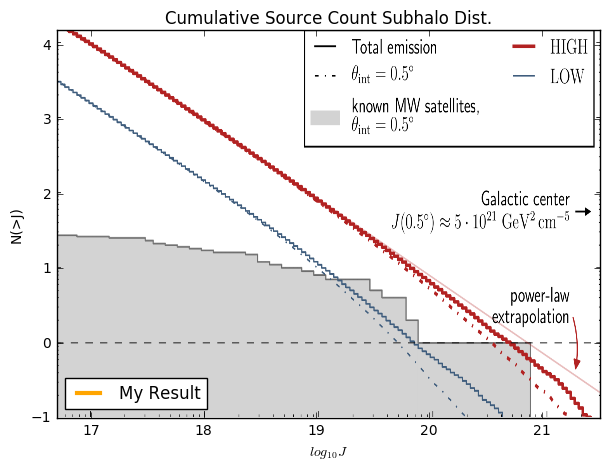

In [37]:
plt.figure(figsize=(7,5))
img = plt.imread("../clumpy.png")
plt.imshow(img, extent=[16.7,21.51, -1,4.3], aspect='auto')
cum_J = []
N = np.sum(J_hist)
for J in J_hist:
    cum_J.append(N)
    N -= J
#plt.plot(bins[1], 20.-bins[1], alpha=0.5)
plt.plot(J_bins[:-1], np.log10(cum_J), c="orange", linewidth=3, label="My Result")
plt.xlim(16.7, 21.51)
plt.ylim(-1,4.2)
plt.xlabel("$log_{10}J$")
plt.ylabel("N(>J)")
plt.title("Cumulative Source Count Subhalo Dist.")
plt.legend(loc=3)

[41800.24110719 20223.88819353  9764.61317114 ... 76757.64374217
  3998.5897849  86606.12332073]


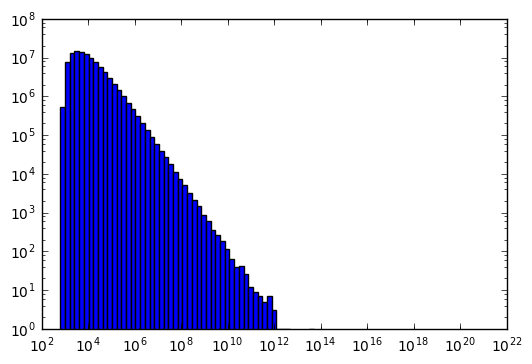

In [35]:
plt.hist(np.load("PS_J/PS_J13.npy"), bins=np.logspace(2,22,100))
plt.yscale("log")
plt.xscale("log")
print(np.load("PS_J/PS_J13.npy"))